# Shop Revenue forecasting using ARIMA

#### Forecast the Revenue for the Shops for the whole 2020 

In [71]:
#import neccesary libraries
import pandas as pd
import warnings
from itertools import cycle, islice
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.model_selection import train_test_split 
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller  


In [72]:
#import dataset
data = pd.read_csv('Shop_revenues.csv',parse_dates=True)
data.head()

,Unnamed: 0,Date,Method,Activity,Shop,Revenue,Number_of_items
0,0,8/1/2017 0:00,order,fitness,A,597.060,58
1,1,8/1/2017 0:00,order,jog/run,B,1062.530,66
2,2,8/1/2017 0:00,order,pilates,B,537.560,46
3,3,8/1/2017 0:00,order,pilates,A,328.255,51
4,4,8/1/2017 0:00,in-human,diving,C,324.355,25


In [73]:
#remove unneccesary columns
data = data.drop(columns=['Unnamed: 0'])

In [74]:
data.head()

,Date,Method,Activity,Shop,Revenue,Number_of_items
0,8/1/2017 0:00,order,fitness,A,597.060,58
1,8/1/2017 0:00,order,jog/run,B,1062.530,66
2,8/1/2017 0:00,order,pilates,B,537.560,46
3,8/1/2017 0:00,order,pilates,A,328.255,51
4,8/1/2017 0:00,in-human,diving,C,324.355,25


In [75]:
#parse date into datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [76]:
data.isnull().sum()

Date               0
Method             0
Activity           0
Shop               0
Revenue            0
Number_of_items    0
dtype: int64

In [77]:
numerical_features = data[['Revenue','Number_of_items']]

In [78]:
numerical_features.describe()

,Revenue,Number_of_items
count,58915.000000,58915.000000
mean,2905.395169,74.134787
std,6367.975960,98.583802
min,-4454.070000,-38.000000
25%,187.382500,27.000000
50%,1016.325000,45.000000
75%,3021.077500,81.000000
max,129466.595000,1781.000000


#### Number of items and Revenue cannot be negative, Has to be corrected

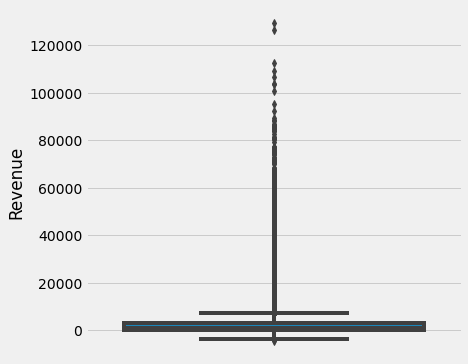

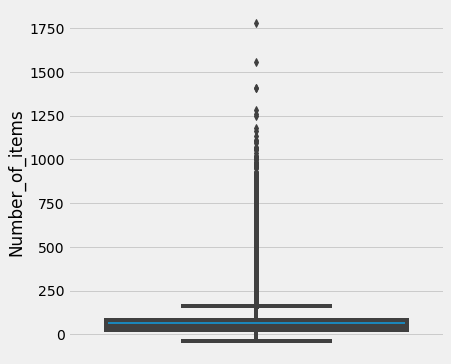

In [79]:
for num in numerical_features:
    plt.figure(figsize=(6,6))
    sns.boxplot(y=num, data = numerical_features)

In [80]:
data = data[data['Number_of_items'] > 0]
data = data[data['Revenue'] > 0]

In [81]:
data.describe()

,Revenue,Number_of_items
count,56816.000000,56816.000000
mean,3017.628127,75.979038
std,6456.959600,99.868595
min,0.320000,1.000000
25%,224.558750,27.000000
50%,1129.430000,46.000000
75%,3132.582500,83.000000
max,129466.595000,1781.000000


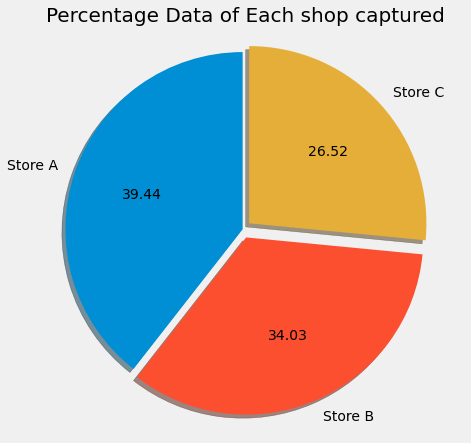

In [82]:
#visualize percentage of each Shop data
fig1, ax1 = plt.subplots(figsize=(7,7))
labels=['Store A','Store B','Store C']
explode=(0,0.05, 0.05)
plt.pie(data['Shop'].value_counts(),labels=labels, explode=explode,shadow=True,
        startangle=90,autopct='%.2f')
ax1.axis('equal');
ax1.set_title('Percentage Data of Each shop captured',fontdict={'size':20});

#### Shop A has the most data captured with 39.44% and store C has the least captured with 26.52%

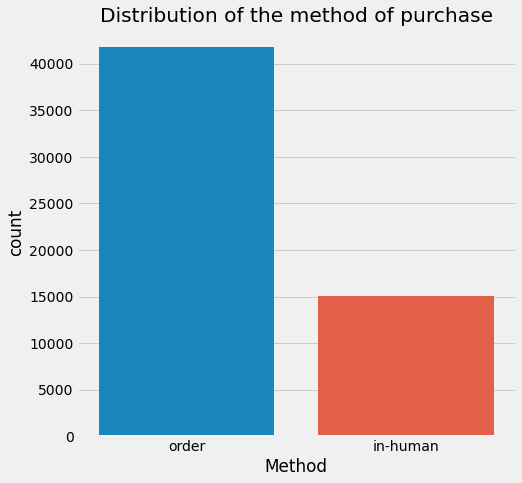

In [83]:
plt.figure(figsize=(7,7))
plt.title('Distribution of the method of purchase')
sns.countplot(x='Method', data=data);

#### Much more customers preferred to purchase sports equipments online, meaning they ordered it, with around 45000 purchases being done online, with only around 15000 purchases being done physically

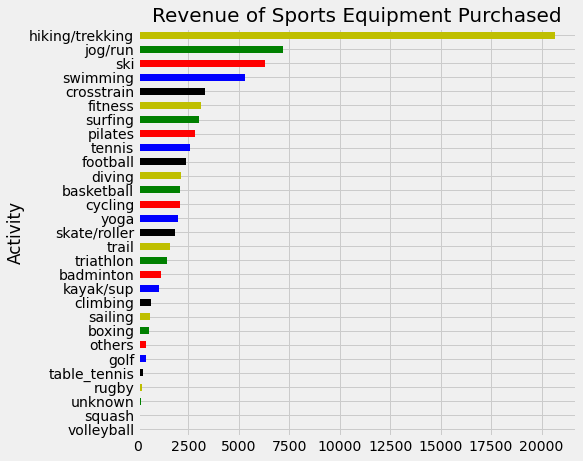

In [84]:
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
ax=data.groupby('Activity')['Revenue'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(7,7), color=my_colors)
ax.set_title('Revenue of Sports Equipment Purchased',fontdict={'size':20});

#### hiking/trekking equipments were purchased the most with over 20000 items being purchased. The second highest equipment purchased was the joggin/running equipments, with only a little under 7500 items purchased. Some itms like volleyball and squash had just single digit purchases

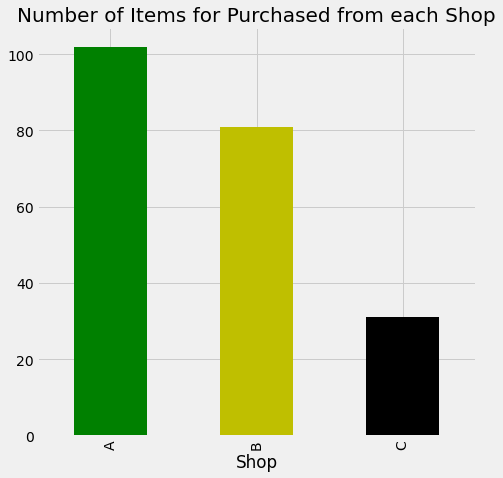

In [85]:
my_colors = list(islice(cycle(['g', 'y', 'k']), None, len(data)))
ax=data.groupby('Shop')['Number_of_items'].mean().sort_values(ascending=False).plot(kind='bar',figsize=(7,7), color=my_colors)
ax.set_title('Number of Items for Purchased from each Shop',fontdict={'size':20});

#### On average, Store A sold the most number of items, with a little over 100 items sold per month,B sold just under 80 items and Shop C sold around 30 items per month

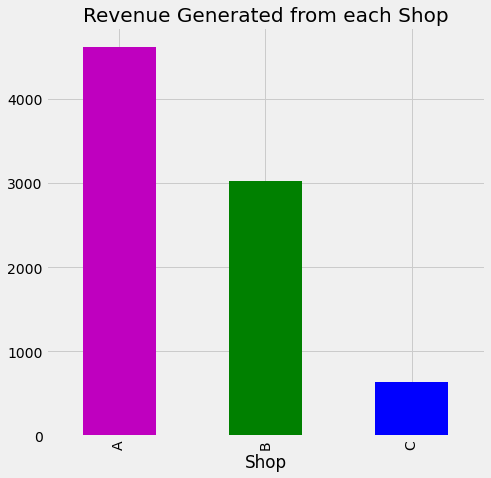

In [86]:
my_colors = list(islice(cycle(['m', 'g', 'b']), None, len(data)))
ax=data.groupby('Shop')['Revenue'].mean().sort_values(ascending=False).plot(kind='bar',figsize=(7,7), color=my_colors)
ax.set_title('Revenue Generated from each Shop',fontdict={'size':20});

#### Shop A generated the most revenue on average, with almost 5000 dollars generated per month. Shop C generates the least with around 500 dollars per month

In [87]:
#filter for each shop
shop_A = data[data['Shop']=='A']
shop_B = data[data['Shop']=='B']
shop_C = data[data['Shop']=='C']

## Shop A

### ARIMA model

In [88]:
shop_A = shop_A[['Date','Revenue']]

In [89]:
Shop_A=shop_A.set_index('Date')

In [90]:
#Check if timeseries data is stationary 
test_result=adfuller(Shop_A['Revenue'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
print(adfuller_test(Shop_A['Revenue']))

ADF Test Statistic : -17.30236859197722
p-value : 5.61857476972338e-30
#Lags Used : 34
Number of Observations Used : 22376
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


#### Shop A's revenue data is stationary, we can proceed

In [91]:
#resampling to include the average revenue for shop A
shop_A_monthly = Shop_A['Revenue'].resample('MS').mean()
shop_A_monthly 

Date
2017-08-01    4147.953482
2017-09-01    3044.141743
2017-10-01    3273.313937
2017-11-01    3524.287984
2017-12-01    5187.620346
2018-01-01    3829.878676
2018-02-01    3231.952149
2018-03-01    4026.839581
2018-04-01    4234.997356
2018-05-01    4295.270316
2018-06-01    4580.474078
2018-07-01    4645.890993
2018-08-01    3935.652765
2018-09-01    3635.047422
2018-10-01    4428.205675
2018-11-01    5201.074140
2018-12-01    7371.869752
2019-01-01    5294.955950
2019-02-01    4430.190907
2019-03-01    4757.460713
2019-04-01    5677.767692
2019-05-01    5127.490036
2019-06-01    5734.901409
2019-07-01    6819.116920
2019-08-01    5841.865297
2019-09-01    4640.800168
2019-10-01    3703.203018
Freq: MS, Name: Revenue, dtype: float64

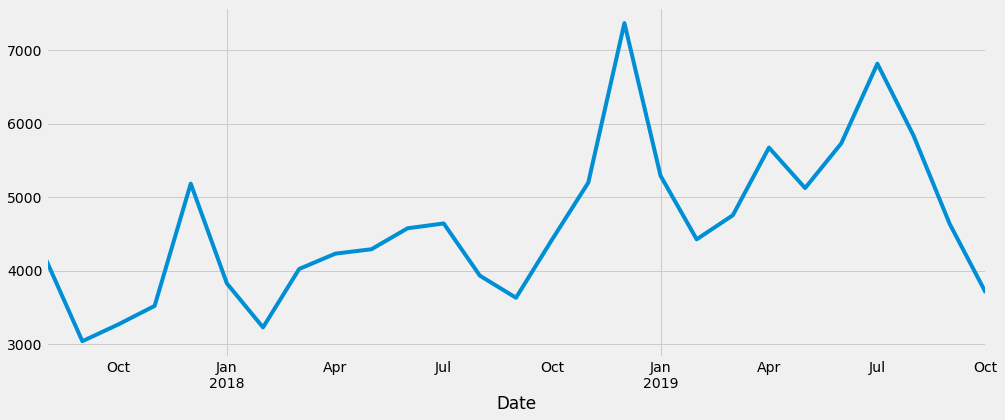

In [92]:
#visualize Store A
shop_A_monthly.plot(figsize=(15, 6))

In [93]:
#hyperparameter tuning parameters for ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [94]:
#Hyperparameter tuning
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model_arima = sm.tsa.statespace.SARIMAX(shop_A_monthly,order=param,
                                               seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_arima_fit = model_arima.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model_arima_fit.aic))
    

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:516.0244428436412
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:250.64132190282513
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:244.5393834488927
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:36.74784531033069
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:245.97703452839468
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:228.52533060983706
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:55.44915746938629
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:38.011598661127394
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:468.94250581350025
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:224.81978477372485
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:217.52398970066363
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5.138509179818457
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:245.12782120468407
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:218.38494471544914
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:54.057463601888536
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:7.7112048551016406
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:447.23511874541254
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:207.958592471810

ARIMA(0, 4, 0)x(1, 0, 1, 12)12 - AIC:191.51729271976296
ARIMA(0, 4, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 4, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(0, 0, 0, 12)12 - AIC:390.00845750820764
ARIMA(0, 4, 1)x(0, 0, 1, 12)12 - AIC:167.90119979662234
ARIMA(0, 4, 1)x(0, 1, 0, 12)12 - AIC:162.46210652192977
ARIMA(0, 4, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(1, 0, 0, 12)12 - AIC:196.97379904093978
ARIMA(0, 4, 1)x(1, 0, 1, 12)12 - AIC:165.91499452568763
ARIMA(0, 4, 1)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(0, 0, 0, 12)12 - AIC:354.84008702259604
ARIMA(0, 4, 2)x(0, 0, 1, 12)12 - AIC:144.6286289407162
ARIMA(0, 4, 2)x(0, 1, 0, 12)12 - AIC:142.31732866594285
ARIMA(0, 4, 2)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(1, 0, 0, 12)12 - AIC:193.19262878918792
ARIMA(0, 4, 2)x(1, 0, 1, 12)12 - AIC:144.91608404644768
ARIMA(0, 4, 2)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(0, 4, 3)x(0, 0, 0, 12)12 - AIC:348.94203684882586


ARIMA(1, 3, 0)x(1, 0, 1, 12)12 - AIC:190.76291826713506
ARIMA(1, 3, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 3, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(0, 0, 0, 12)12 - AIC:386.77131699224697
ARIMA(1, 3, 1)x(0, 0, 1, 12)12 - AIC:176.44923061502607
ARIMA(1, 3, 1)x(0, 1, 0, 12)12 - AIC:172.05270065616438
ARIMA(1, 3, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(1, 0, 0, 12)12 - AIC:188.83496906809918
ARIMA(1, 3, 1)x(1, 0, 1, 12)12 - AIC:174.81723113045922
ARIMA(1, 3, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(0, 0, 0, 12)12 - AIC:366.2012668919923
ARIMA(1, 3, 2)x(0, 0, 1, 12)12 - AIC:158.5940136944704
ARIMA(1, 3, 2)x(0, 1, 0, 12)12 - AIC:155.0005011446968
ARIMA(1, 3, 2)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(1, 0, 0, 12)12 - AIC:191.11231834137809
ARIMA(1, 3, 2)x(1, 0, 1, 12)12 - AIC:159.57780159386817
ARIMA(1, 3, 2)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 3, 3)x(0, 0, 0, 12)12 - AIC:347.9001269755627


ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:190.488447739775
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:186.451624322864
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:189.06043540233952
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:190.3493715238926
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:378.1564127236802
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:179.565427301151
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:171.3972554682725
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:190.75081399376305
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:175.7779551311998
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 3)x(0, 0, 0, 12)12 - AIC:356.85849203560906
ARIMA(2, 2, 3)x(0, 0, 1, 12)12 - AIC:154.27828371189472
ARIMA(2, 2, 3)x(0, 1, 0, 12)12 - AIC:158.33871615634334
ARIMA(2, 2, 3)x(0, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 3)x(1, 0, 0, 12)12 - AIC:190.537

ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:184.6148728732337
ARIMA(3, 1, 1)x(1, 0, 1, 12)12 - AIC:184.62382747225726
ARIMA(3, 1, 1)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(3, 1, 1)x(1, 1, 1, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(0, 0, 0, 12)12 - AIC:386.6396311351234
ARIMA(3, 1, 2)x(0, 0, 1, 12)12 - AIC:189.79314414515378
ARIMA(3, 1, 2)x(0, 1, 0, 12)12 - AIC:183.49852147977649
ARIMA(3, 1, 2)x(0, 1, 1, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(1, 0, 0, 12)12 - AIC:185.8298631387015
ARIMA(3, 1, 2)x(1, 0, 1, 12)12 - AIC:184.6353638445723
ARIMA(3, 1, 2)x(1, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(1, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(0, 0, 0, 12)12 - AIC:367.6312976506187
ARIMA(3, 1, 3)x(0, 0, 1, 12)12 - AIC:172.6461726863958
ARIMA(3, 1, 3)x(0, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 1, 3)x(0, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(1, 0, 0, 12)12 - AIC:188.32078183792717
ARIMA(3, 1, 3)x(1, 0, 1, 12)12 - AIC:171.59240808870024
ARIMA(3, 1, 3)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(3, 1, 

ARIMA(4, 0, 2)x(0, 0, 0, 12)12 - AIC:386.1991812366166
ARIMA(4, 0, 2)x(0, 0, 1, 12)12 - AIC:209.37860425773187
ARIMA(4, 0, 2)x(0, 1, 0, 12)12 - AIC:185.02613391035558
ARIMA(4, 0, 2)x(0, 1, 1, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(1, 0, 0, 12)12 - AIC:188.3398223431597
ARIMA(4, 0, 2)x(1, 0, 1, 12)12 - AIC:190.2503328665784
ARIMA(4, 0, 2)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(0, 0, 0, 12)12 - AIC:388.60612260764395
ARIMA(4, 0, 3)x(0, 0, 1, 12)12 - AIC:195.34907869498818
ARIMA(4, 0, 3)x(0, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 0, 3)x(0, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(1, 0, 0, 12)12 - AIC:190.2543420273381
ARIMA(4, 0, 3)x(1, 0, 1, 12)12 - AIC:192.22316092310757
ARIMA(4, 0, 3)x(1, 1, 0, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(1, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 0, 4)x(0, 0, 0, 12)12 - AIC:372.0025752667137
ARIMA(4, 0, 4)x(0, 0, 1, 12)12 - AIC:178.62080719097776
ARIMA(4, 0, 4)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(4, 0, 4)x(0, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 0, 

ARIMA(4, 4, 2)x(1, 0, 0, 12)12 - AIC:133.3955371068289
ARIMA(4, 4, 2)x(1, 0, 1, 12)12 - AIC:135.4437112698508
ARIMA(4, 4, 2)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 4, 2)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(0, 0, 0, 12)12 - AIC:344.95123602009255
ARIMA(4, 4, 3)x(0, 0, 1, 12)12 - AIC:129.39256288290426
ARIMA(4, 4, 3)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(4, 4, 3)x(0, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(1, 0, 0, 12)12 - AIC:128.6261505366167
ARIMA(4, 4, 3)x(1, 0, 1, 12)12 - AIC:130.86457815470598
ARIMA(4, 4, 3)x(1, 1, 0, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(1, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(0, 0, 0, 12)12 - AIC:322.49825703766265
ARIMA(4, 4, 4)x(0, 0, 1, 12)12 - AIC:112.64255016785462
ARIMA(4, 4, 4)x(0, 1, 0, 12)12 - AIC:121.84178142957285
ARIMA(4, 4, 4)x(0, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(1, 0, 0, 12)12 - AIC:130.10071011056942
ARIMA(4, 4, 4)x(1, 0, 1, 12)12 - AIC:114.95545665068846
ARIMA(4, 4, 4)x(1, 1, 0, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(1, 1, 1, 12)12 - AIC:22.0


#### The combination with the lowest reasonable AIC should be selected, and plugged into the ARIMA model

In [95]:
arima_shop_A = sm.tsa.statespace.SARIMAX(shop_A_monthly,order=(0, 1, 3),seasonal_order=(1, 1, 1, 12),
                                eenforce_invertibility=False)
                                
results = arima_shop_A.fit()

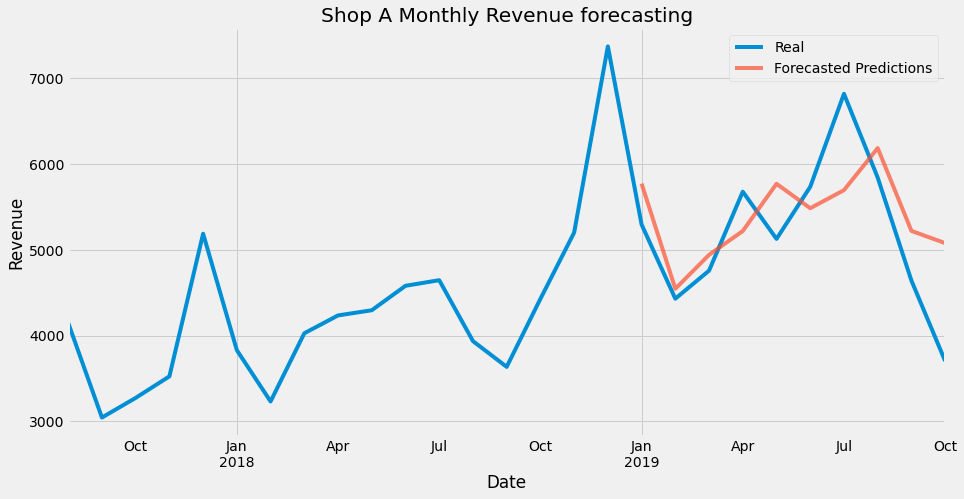

The Root Mean Squared Error of our forecasts is 675.82


In [96]:
pred = results.get_prediction('2019-01-01', dynamic=False)
ax = shop_A_monthly['2017':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecasted Predictions', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.title('Shop A Monthly Revenue forecasting')
plt.show()
y_forecasted = pred.predicted_mean
y_truth = shop_A_monthly['2017-08-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

#### The model does well to predict the trend of the Revenue, and with a RMSE of 626.77, we can proceed to forecast for 2020 with it

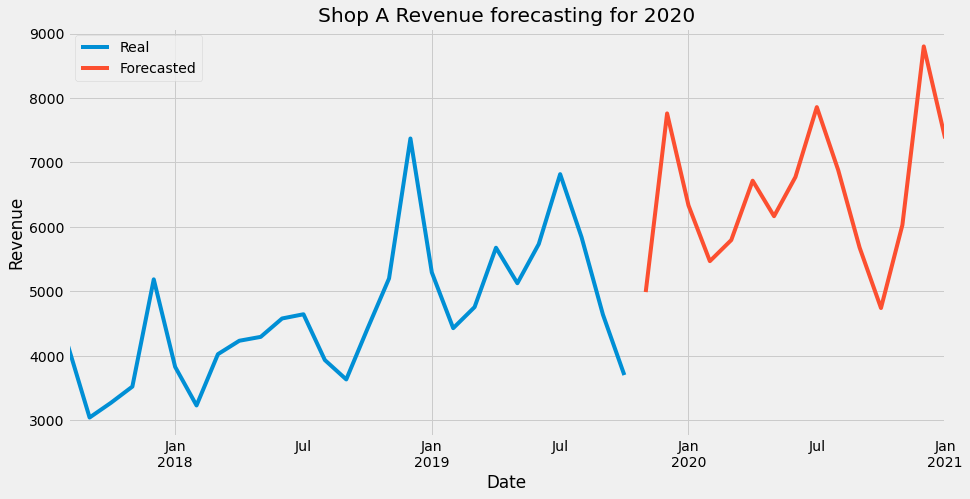

In [97]:
prediction = results.get_forecast('2020-12-31')
ax = shop_A_monthly.plot(label='Real', figsize=(14, 7))
prediction.predicted_mean.plot(ax=ax, label='Forecasted')
ax.set_ylabel('Revenue')
plt.title('Shop A Revenue forecasting for 2020')
plt.legend()
plt.show()

#### The model predicts the Revenue for the whole 2020, the data from october to december 2019 wasnt included in the dataset, thats why theres a gap 

In [98]:
shop_A_monthly.head(18)

Date
2017-08-01    4147.953482
2017-09-01    3044.141743
2017-10-01    3273.313937
2017-11-01    3524.287984
2017-12-01    5187.620346
2018-01-01    3829.878676
2018-02-01    3231.952149
2018-03-01    4026.839581
2018-04-01    4234.997356
2018-05-01    4295.270316
2018-06-01    4580.474078
2018-07-01    4645.890993
2018-08-01    3935.652765
2018-09-01    3635.047422
2018-10-01    4428.205675
2018-11-01    5201.074140
2018-12-01    7371.869752
2019-01-01    5294.955950
Freq: MS, Name: Revenue, dtype: float64

## Shop B

In [99]:
shop_B = shop_B[['Date','Revenue']]

In [100]:
shop_B

,Date,Revenue
1,2017-08-01,1062.530
2,2017-08-01,537.560
11,2017-08-01,4.885
12,2017-08-01,598.935
13,2017-08-01,463.095
...,...,...
58906,2019-10-31,343.180
58907,2019-10-31,240.455
58909,2019-10-31,656.915
58911,2019-10-31,148.570


In [101]:
shop_B=shop_B.set_index('Date')

In [102]:
#Check if timeseries data is stationary 
test_result=adfuller(shop_B['Revenue'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
print(adfuller_test(shop_B['Revenue']))

ADF Test Statistic : -18.131675202483937
p-value : 2.5050436720954944e-30
#Lags Used : 29
Number of Observations Used : 19305
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


#### Shop B's revenue is also stationary, we can proceed

In [103]:
shop_B_monthly = shop_B['Revenue'].resample('MS').mean()
shop_B_monthly

Date
2017-08-01    2506.279458
2017-09-01    2040.798471
2017-10-01    2495.585508
2017-11-01    2726.179245
2017-12-01    3798.321697
2018-01-01    2604.518449
2018-02-01    2369.301565
2018-03-01    3201.996328
2018-04-01    3326.128019
2018-05-01    3321.244250
2018-06-01    3345.942334
2018-07-01    3296.945799
2018-08-01    2863.622901
2018-09-01    2679.892182
2018-10-01    3170.242299
2018-11-01    3331.314397
2018-12-01    4455.538700
2019-01-01    2970.071761
2019-02-01    2666.441156
2019-03-01    2907.028381
2019-04-01    3372.221957
2019-05-01    3008.232364
2019-06-01    3285.424698
2019-07-01    3451.536947
2019-08-01    3133.398986
2019-09-01    2678.327969
2019-10-01    2439.876176
Freq: MS, Name: Revenue, dtype: float64

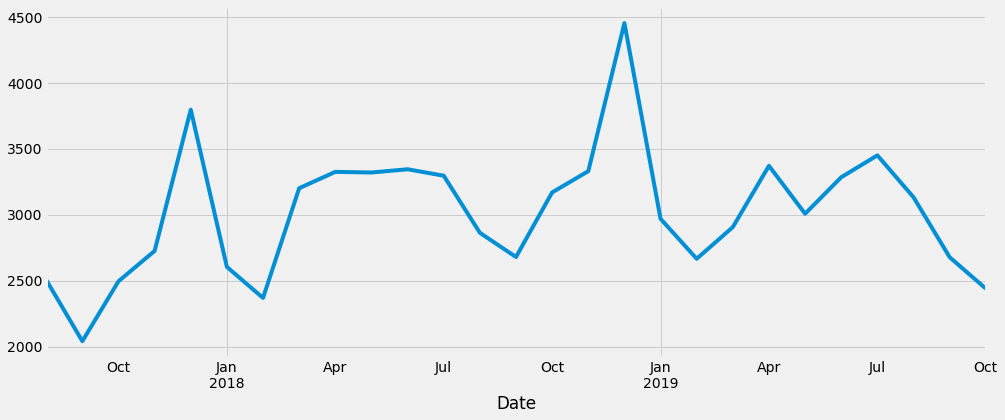

In [104]:
shop_B_monthly.plot(figsize=(15, 6))

In [105]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model_arima = sm.tsa.statespace.SARIMAX(shop_B_monthly,order=param,
                                               seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_arima_fit = model_arima.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model_arima_fit.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:493.4074696636804
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:241.26996717093166
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:212.12966361320215
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:33.119307953418954
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:226.91012605040012
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:214.3437713599606
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:48.24838916012869
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:35.09450608412419
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:448.82220912266257
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:216.5289776055235
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:193.08671201888862
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3.551085809080946
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:224.5197022738467
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:198.09651357129627
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:49.56820074517476
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6.0161594113425565
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:424.0076481403134
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:198.670871287432
ARI

ARIMA(0, 4, 0)x(1, 0, 0, 12)12 - AIC:198.4510654163942
ARIMA(0, 4, 0)x(1, 0, 1, 12)12 - AIC:183.7250222325042
ARIMA(0, 4, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 4, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(0, 0, 0, 12)12 - AIC:373.39938001498024
ARIMA(0, 4, 1)x(0, 0, 1, 12)12 - AIC:158.1526987695371
ARIMA(0, 4, 1)x(0, 1, 0, 12)12 - AIC:153.6444747740489
ARIMA(0, 4, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(1, 0, 0, 12)12 - AIC:187.2536435800593
ARIMA(0, 4, 1)x(1, 0, 1, 12)12 - AIC:157.55583969550653
ARIMA(0, 4, 1)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(0, 0, 0, 12)12 - AIC:335.3695915521106
ARIMA(0, 4, 2)x(0, 0, 1, 12)12 - AIC:131.9832713155974
ARIMA(0, 4, 2)x(0, 1, 0, 12)12 - AIC:131.79992620767018
ARIMA(0, 4, 2)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(1, 0, 0, 12)12 - AIC:179.6681424518114
ARIMA(0, 4, 2)x(1, 0, 1, 12)12 - AIC:130.08601969483246
ARIMA(0, 4, 2)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(0

ARIMA(1, 3, 0)x(1, 0, 1, 12)12 - AIC:171.47285447910224
ARIMA(1, 3, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 3, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(0, 0, 0, 12)12 - AIC:365.5802503618364
ARIMA(1, 3, 1)x(0, 0, 1, 12)12 - AIC:166.00955797509744
ARIMA(1, 3, 1)x(0, 1, 0, 12)12 - AIC:154.0142633560948
ARIMA(1, 3, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(1, 0, 0, 12)12 - AIC:169.62992672805473
ARIMA(1, 3, 1)x(1, 0, 1, 12)12 - AIC:157.12769566378702
ARIMA(1, 3, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(0, 0, 0, 12)12 - AIC:335.6222442639982
ARIMA(1, 3, 2)x(0, 0, 1, 12)12 - AIC:145.18231105105744
ARIMA(1, 3, 2)x(0, 1, 0, 12)12 - AIC:139.49298419706017
ARIMA(1, 3, 2)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(1, 0, 0, 12)12 - AIC:169.25355181774225
ARIMA(1, 3, 2)x(1, 0, 1, 12)12 - AIC:142.90811615070834
ARIMA(1, 3, 2)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 3, 3)x(0, 0, 0, 12)12 - AIC:319.2850034393945


ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:179.2978859940638
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:168.16825316343315
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:169.24013845883192
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:169.6715590046639
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:354.4818541971519
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:164.17507874697733
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:156.13072824466462
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:166.13372923452053
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:159.65758694316804
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 3)x(0, 0, 0, 12)12 - AIC:324.91884196069475
ARIMA(2, 2, 3)x(0, 0, 1, 12)12 - AIC:137.6856370841698
ARIMA(2, 2, 3)x(0, 1, 0, 12)12 - AIC:146.04916403182352
ARIMA(2, 2, 3)x(0, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 3)x(1, 0, 0, 12)12 - AIC:1

ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:168.7342297344773
ARIMA(3, 1, 1)x(1, 0, 1, 12)12 - AIC:170.31058294856757
ARIMA(3, 1, 1)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(3, 1, 1)x(1, 1, 1, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(0, 0, 0, 12)12 - AIC:361.35192046125763
ARIMA(3, 1, 2)x(0, 0, 1, 12)12 - AIC:176.43952734392883
ARIMA(3, 1, 2)x(0, 1, 0, 12)12 - AIC:166.80767806750012
ARIMA(3, 1, 2)x(0, 1, 1, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(1, 0, 0, 12)12 - AIC:168.08841252009947
ARIMA(3, 1, 2)x(1, 0, 1, 12)12 - AIC:170.13957102925787
ARIMA(3, 1, 2)x(1, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(1, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(0, 0, 0, 12)12 - AIC:343.1964092033752
ARIMA(3, 1, 3)x(0, 0, 1, 12)12 - AIC:155.14287394706247
ARIMA(3, 1, 3)x(0, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 1, 3)x(0, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(1, 0, 0, 12)12 - AIC:169.78186594799595
ARIMA(3, 1, 3)x(1, 0, 1, 12)12 - AIC:155.67687115013385
ARIMA(3, 1, 3)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(3,

ARIMA(4, 0, 2)x(0, 0, 0, 12)12 - AIC:361.94276285957216
ARIMA(4, 0, 2)x(0, 0, 1, 12)12 - AIC:193.0011585607506
ARIMA(4, 0, 2)x(0, 1, 0, 12)12 - AIC:165.2412547012597
ARIMA(4, 0, 2)x(0, 1, 1, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(1, 0, 0, 12)12 - AIC:172.2186481514854
ARIMA(4, 0, 2)x(1, 0, 1, 12)12 - AIC:174.28769581961234
ARIMA(4, 0, 2)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(0, 0, 0, 12)12 - AIC:363.03150269074575
ARIMA(4, 0, 3)x(0, 0, 1, 12)12 - AIC:178.99480226979452
ARIMA(4, 0, 3)x(0, 1, 0, 12)12 - AIC:412993619395.98914
ARIMA(4, 0, 3)x(0, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(1, 0, 0, 12)12 - AIC:172.7340123590041
ARIMA(4, 0, 3)x(1, 0, 1, 12)12 - AIC:174.7260913786098
ARIMA(4, 0, 3)x(1, 1, 0, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(1, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 0, 4)x(0, 0, 0, 12)12 - AIC:342.5529779079437
ARIMA(4, 0, 4)x(0, 0, 1, 12)12 - AIC:158.1963766459124
ARIMA(4, 0, 4)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(4, 0, 4)x(0, 1, 1, 12)12 - AIC:20.0


ARIMA(4, 4, 2)x(1, 0, 0, 12)12 - AIC:125.78136684478409
ARIMA(4, 4, 2)x(1, 0, 1, 12)12 - AIC:127.7769244376517
ARIMA(4, 4, 2)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 4, 2)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(0, 0, 0, 12)12 - AIC:325.33566002302
ARIMA(4, 4, 3)x(0, 0, 1, 12)12 - AIC:123.9176165993537
ARIMA(4, 4, 3)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(4, 4, 3)x(0, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(1, 0, 0, 12)12 - AIC:123.85704127515939
ARIMA(4, 4, 3)x(1, 0, 1, 12)12 - AIC:125.85469555907572
ARIMA(4, 4, 3)x(1, 1, 0, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(1, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(0, 0, 0, 12)12 - AIC:299.38011815036646
ARIMA(4, 4, 4)x(0, 0, 1, 12)12 - AIC:102.5413131701687
ARIMA(4, 4, 4)x(0, 1, 0, 12)12 - AIC:116.27887146613001
ARIMA(4, 4, 4)x(0, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(1, 0, 0, 12)12 - AIC:116.12086229510533
ARIMA(4, 4, 4)x(1, 0, 1, 12)12 - AIC:104.646100704704
ARIMA(4, 4, 4)x(1, 1, 0, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(1, 1, 1, 12)12 - AIC:22.0


In [106]:
mod = sm.tsa.statespace.SARIMAX(shop_B_monthly,order=(0, 0, 2),seasonal_order=(1, 1, 1, 12),
                                eenforce_invertibility=False)
                                
results = mod.fit()

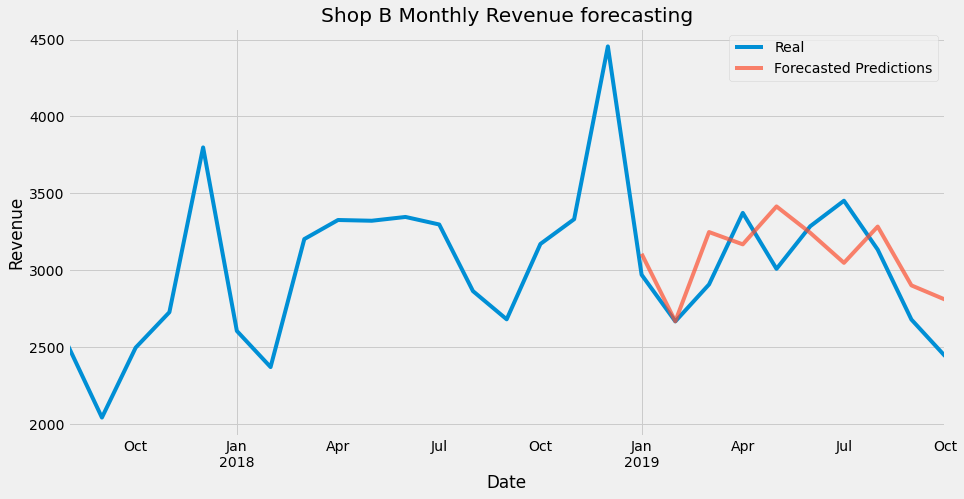

The Root Mean Squared Error of our forecasts is 267.22


In [107]:
pred = results.get_prediction('2019-01-01', dynamic=False)
ax = shop_B_monthly['2017':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecasted Predictions', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.title('Shop B Monthly Revenue forecasting')
plt.show()
y_forecasted = pred.predicted_mean
y_truth = shop_B_monthly['2017-08-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

#### The optimized ARIMA model does well to predict the revenue, since the trend is almost similar, with a RMSE of 246.67, we can now use this to forecast the future revenue of 2020

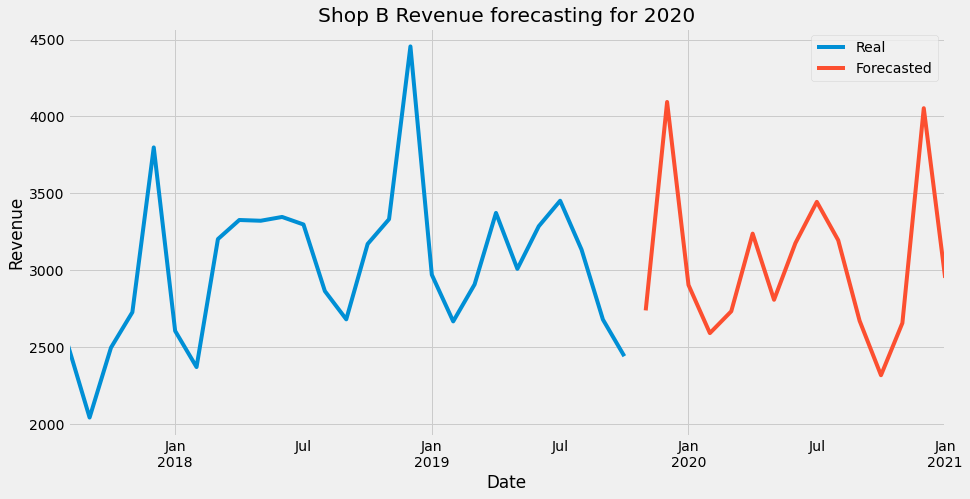

In [108]:
prediction = results.get_forecast('2020-12-31')
ax = shop_B_monthly.plot(label='Real', figsize=(14, 7))
prediction.predicted_mean.plot(ax=ax, label='Forecasted')
ax.set_ylabel('Revenue')
plt.title('Shop B Revenue forecasting for 2020')
plt.legend()
plt.show()

## Shop C

In [109]:
shop_C = shop_C[['Date','Revenue']]

In [110]:
shop_C=shop_C.set_index('Date')

In [111]:
#Check if timeseries data is stationary 
test_result=adfuller(shop_C['Revenue'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
print(adfuller_test(shop_C['Revenue']))

ADF Test Statistic : -12.600094805782929
p-value : 1.7438638812924954e-23
#Lags Used : 39
Number of Observations Used : 15030
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


#### Shop C's revenue is also stationary, so we can proceed as well 

In [112]:
shop_C_monthly = shop_C['Revenue'].resample('MS').mean()
shop_C_monthly

Date
2017-08-01    400.300442
2017-09-01    436.154200
2017-10-01    421.120176
2017-11-01    692.429592
2017-12-01    659.487244
2018-01-01    978.587520
2018-02-01    562.362472
2018-03-01    500.647146
2018-04-01    512.648429
2018-05-01    547.624153
2018-06-01    522.159287
2018-07-01    374.491206
2018-08-01    446.612968
2018-09-01    509.042984
2018-10-01    634.261612
2018-11-01    750.471078
2018-12-01    889.746285
2019-01-01    855.599741
2019-02-01    647.189333
2019-03-01    638.080228
2019-04-01    644.646040
2019-05-01    546.380773
2019-06-01    659.646063
2019-07-01    754.247717
2019-08-01    715.495863
2019-09-01    729.815642
2019-10-01    956.998948
Freq: MS, Name: Revenue, dtype: float64

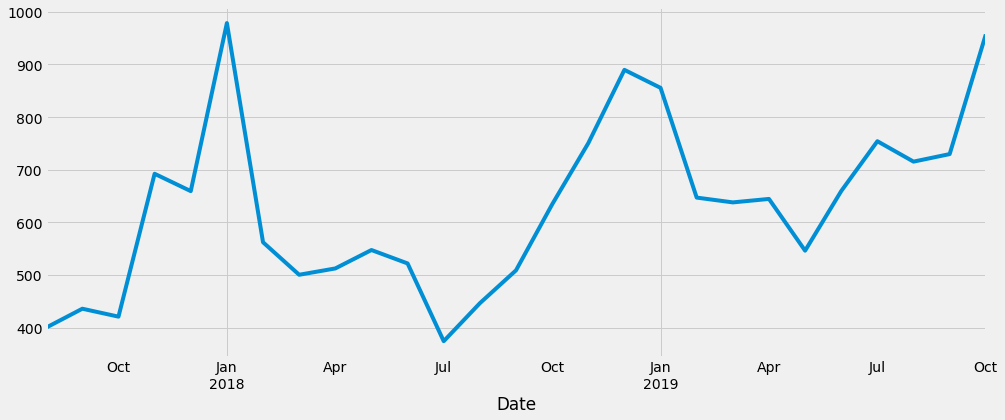

In [113]:
shop_C_monthly.plot(figsize=(15, 6))

In [114]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model_arima = sm.tsa.statespace.SARIMAX(shop_C_monthly,order=param,
                                               seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_arima_fit = model_arima.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model_arima_fit.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:413.1710648536713
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:222.41851881310316
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:189.93437854182997
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:30.9338696192971
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:196.4699541173768
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:185.94976887408967
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:41.43126439319859
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:28.867657062270958
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:372.99843598354215
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:195.45075864497065
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:176.0410510984286
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:19.238991478739795
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:198.66362393
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:175.5917765111532
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:43.482210324841105
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1.472541928350478
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:344.77453948172297
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:173.45250243037756
ARIMA(

ARIMA(0, 4, 0)x(0, 0, 1, 12)12 - AIC:148.85832771135125
ARIMA(0, 4, 0)x(0, 1, 0, 12)12 - AIC:169.82077989542796
ARIMA(0, 4, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 4, 0)x(1, 0, 0, 12)12 - AIC:161.96260962390178
ARIMA(0, 4, 0)x(1, 0, 1, 12)12 - AIC:150.44053808572045
ARIMA(0, 4, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 4, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(0, 0, 0, 12)12 - AIC:315.5500474855828
ARIMA(0, 4, 1)x(0, 0, 1, 12)12 - AIC:129.44705947316496
ARIMA(0, 4, 1)x(0, 1, 0, 12)12 - AIC:142.84498618942402
ARIMA(0, 4, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(1, 0, 0, 12)12 - AIC:154.80257385517956
ARIMA(0, 4, 1)x(1, 0, 1, 12)12 - AIC:130.43674933685162
ARIMA(0, 4, 1)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 4, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(0, 0, 0, 12)12 - AIC:274.5805379022846
ARIMA(0, 4, 2)x(0, 0, 1, 12)12 - AIC:112.5984067692285
ARIMA(0, 4, 2)x(0, 1, 0, 12)12 - AIC:116.04869550984496
ARIMA(0, 4, 2)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 4, 2)x(1, 0, 0, 12)12 - AIC:151.477

ARIMA(1, 3, 0)x(0, 0, 1, 12)12 - AIC:152.84131947776308
ARIMA(1, 3, 0)x(0, 1, 0, 12)12 - AIC:163.63766229099684
ARIMA(1, 3, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 3, 0)x(1, 0, 0, 12)12 - AIC:152.72264635847625
ARIMA(1, 3, 0)x(1, 0, 1, 12)12 - AIC:154.3278760227135
ARIMA(1, 3, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 3, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(0, 0, 0, 12)12 - AIC:299.56011221146105
ARIMA(1, 3, 1)x(0, 0, 1, 12)12 - AIC:136.73323694611307
ARIMA(1, 3, 1)x(0, 1, 0, 12)12 - AIC:144.2481483858812
ARIMA(1, 3, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(1, 0, 0, 12)12 - AIC:149.12133123689364
ARIMA(1, 3, 1)x(1, 0, 1, 12)12 - AIC:138.3425279427779
ARIMA(1, 3, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 3, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(0, 0, 0, 12)12 - AIC:284.1598304709188
ARIMA(1, 3, 2)x(0, 0, 1, 12)12 - AIC:123.86741595375986
ARIMA(1, 3, 2)x(0, 1, 0, 12)12 - AIC:131.7295545041221
ARIMA(1, 3, 2)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 3, 2)x(1, 0, 0, 12)12 - AIC:149.420

ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:141.61323561500205
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:142.16987376928338
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:304.770921150706
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:142.6386085422189
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:149.91111139588304
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:143.41301841427207
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:143.82946690918925
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:290.93814243684915
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:134.21350798372808
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:138.43401394994697
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:145.4494969569262
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:132.53635625951395
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:14

ARIMA(3, 1, 1)x(0, 0, 0, 12)12 - AIC:300.89788210311696
ARIMA(3, 1, 1)x(0, 0, 1, 12)12 - AIC:152.45497007307875
ARIMA(3, 1, 1)x(0, 1, 0, 12)12 - AIC:148.6036739602155
ARIMA(3, 1, 1)x(0, 1, 1, 12)12 - AIC:12.0
ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:142.36867795519652
ARIMA(3, 1, 1)x(1, 0, 1, 12)12 - AIC:144.2125922056701
ARIMA(3, 1, 1)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(3, 1, 1)x(1, 1, 1, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(0, 0, 0, 12)12 - AIC:301.1882056948066
ARIMA(3, 1, 2)x(0, 0, 1, 12)12 - AIC:141.20862897315908
ARIMA(3, 1, 2)x(0, 1, 0, 12)12 - AIC:147.71412608196903
ARIMA(3, 1, 2)x(0, 1, 1, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(1, 0, 0, 12)12 - AIC:138.8610903713801
ARIMA(3, 1, 2)x(1, 0, 1, 12)12 - AIC:146.13865357593457
ARIMA(3, 1, 2)x(1, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 1, 2)x(1, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 1, 3)x(0, 0, 0, 12)12 - AIC:281.71432204976884
ARIMA(3, 1, 3)x(0, 0, 1, 12)12 - AIC:130.846598913935
ARIMA(3, 1, 3)x(0, 1, 0, 12)12 - AIC:32626060831.471176
ARIMA(3, 1, 3)x(0, 1, 1, 1

ARIMA(4, 0, 1)x(0, 1, 1, 12)12 - AIC:8.685568043486434
ARIMA(4, 0, 1)x(1, 0, 0, 12)12 - AIC:144.4525740456628
ARIMA(4, 0, 1)x(1, 0, 1, 12)12 - AIC:147.75365922676247
ARIMA(4, 0, 1)x(1, 1, 0, 12)12 - AIC:14.0
ARIMA(4, 0, 1)x(1, 1, 1, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(0, 0, 0, 12)12 - AIC:300.8162199543452
ARIMA(4, 0, 2)x(0, 0, 1, 12)12 - AIC:159.722751150988
ARIMA(4, 0, 2)x(0, 1, 0, 12)12 - AIC:147.9476094740203
ARIMA(4, 0, 2)x(0, 1, 1, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(1, 0, 0, 12)12 - AIC:147.7308571136698
ARIMA(4, 0, 2)x(1, 0, 1, 12)12 - AIC:149.75132558064274
ARIMA(4, 0, 2)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 0, 2)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(0, 0, 0, 12)12 - AIC:303.73131292772814
ARIMA(4, 0, 3)x(0, 0, 1, 12)12 - AIC:148.49589500174056
ARIMA(4, 0, 3)x(0, 1, 0, 12)12 - AIC:11572472628.8843
ARIMA(4, 0, 3)x(0, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 0, 3)x(1, 0, 0, 12)12 - AIC:145.71466803781084
ARIMA(4, 0, 3)x(1, 0, 1, 12)12 - AIC:149.28622296283453
ARIMA(4, 0, 3)x(1, 1, 0, 12)1

ARIMA(4, 4, 2)x(0, 0, 0, 12)12 - AIC:250.5427128806504
ARIMA(4, 4, 2)x(0, 0, 1, 12)12 - AIC:108.19443002506384
ARIMA(4, 4, 2)x(0, 1, 0, 12)12 - AIC:14.0
ARIMA(4, 4, 2)x(0, 1, 1, 12)12 - AIC:16.0
ARIMA(4, 4, 2)x(1, 0, 0, 12)12 - AIC:97.00506236668218
ARIMA(4, 4, 2)x(1, 0, 1, 12)12 - AIC:99.02130073262046
ARIMA(4, 4, 2)x(1, 1, 0, 12)12 - AIC:16.0
ARIMA(4, 4, 2)x(1, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(0, 0, 0, 12)12 - AIC:251.61221996816363
ARIMA(4, 4, 3)x(0, 0, 1, 12)12 - AIC:91.59227438988026
ARIMA(4, 4, 3)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(4, 4, 3)x(0, 1, 1, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(1, 0, 0, 12)12 - AIC:97.26802295085506
ARIMA(4, 4, 3)x(1, 0, 1, 12)12 - AIC:100.06823351689731
ARIMA(4, 4, 3)x(1, 1, 0, 12)12 - AIC:18.0
ARIMA(4, 4, 3)x(1, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 4, 4)x(0, 0, 0, 12)12 - AIC:243.99270360308742
ARIMA(4, 4, 4)x(0, 0, 1, 12)12 - AIC:90.37243791666836
ARIMA(4, 4, 4)x(0, 1, 0, 12)12 - AIC:109.09129558326065
ARIMA(4, 4, 4)x(0, 1, 1, 12)12 - AIC:20.0
ARIMA(4, 4, 4

In [115]:
mod = sm.tsa.statespace.SARIMAX(shop_C_monthly,order=(0, 2, 4),seasonal_order=(0, 1, 1, 12),
                                eenforce_invertibility=False)
                                
results = mod.fit()

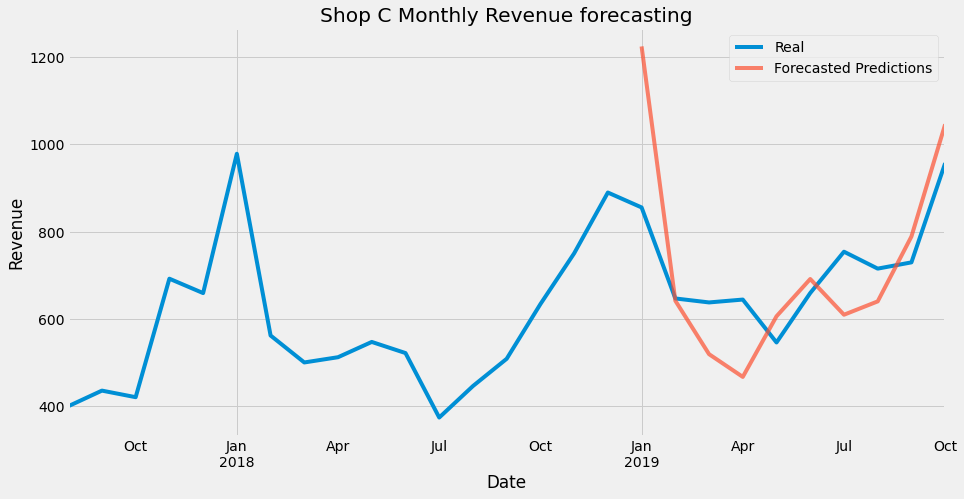

The Root Mean Squared Error of our forecasts is 149.63


In [116]:
pred = results.get_prediction('2019-01-01', dynamic=False)
ax = shop_C_monthly['2017':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecasted Predictions', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.title('Shop C Monthly Revenue forecasting')
plt.show()
y_forecasted = pred.predicted_mean
y_truth = shop_C_monthly['2017-08-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

#### With a rmse of 144.74, and the trend of forecast almost matching that of the actual revenue, the model does very well and cna now be used to forecast for 2020

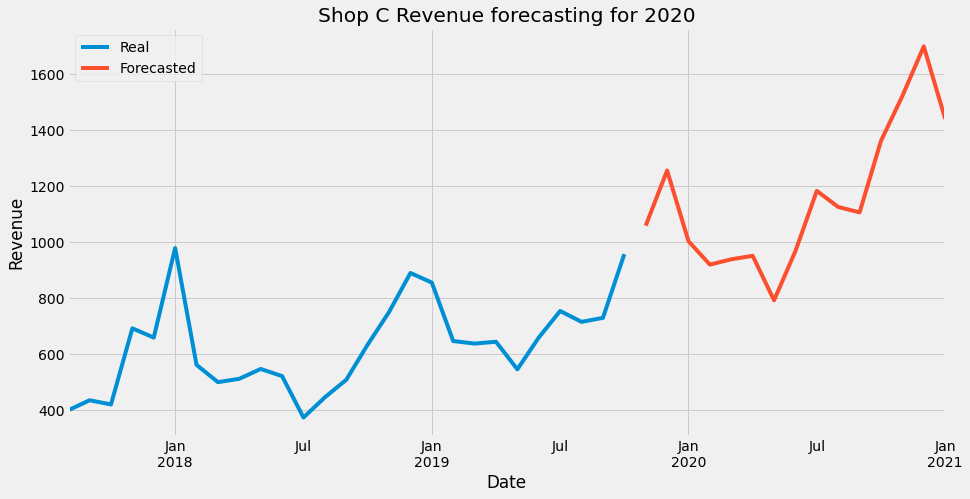

In [117]:
prediction = results.get_forecast('2020-12-31')
ax = shop_C_monthly.plot(label='Real', figsize=(14, 7))
prediction.predicted_mean.plot(ax=ax, label='Forecasted')
ax.set_ylabel('Revenue')
plt.title('Shop C Revenue forecasting for 2020')
plt.legend()
plt.show()